## Tinh chỉnh (hyperparameter tuning)

### Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from scipy.stats import randint, uniform
import joblib

### Load dữ liệu

In [2]:
df_train = pd.read_excel("../exps/data/train_feat.xlsx")
df_valid = pd.read_excel("../exps/data/valid_feat.xlsx")
test = pd.read_excel("../exps/data/test_feat.xlsx")

### Xử lý dữ liệu trước khi train

In [3]:
# Loại bỏ cột không cần thiết
drop_cols = ["Ticket", "Cabin", "SibSp", "Parch"]
for col in drop_cols:
    if col in df_train.columns:
        df_train.drop(columns=col, inplace=True, errors="ignore")
        df_valid.drop(columns=col, inplace=True, errors="ignore")
        test.drop(columns=col, inplace=True, errors="ignore")

# Xử lý các cột phân loại (Label Encoding)
cat_cols = df_train.select_dtypes(include="object").columns
le = LabelEncoder()
for col in cat_cols:
    all_vals = pd.concat([df_train[col], df_valid[col], test[col]], axis=0).astype(str)
    le.fit(all_vals)

    df_train[col] = le.transform(df_train[col].astype(str))
    df_valid[col] = le.transform(df_valid[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

print("Hoàn tất xử lý dữ liệu trước train")
df_train.head()

Hoàn tất xử lý dữ liệu trước train


,Survived,Pclass,Sex,Age,Fare,Embarked,HasCabin,Deck,Title,FamilySize,IsAlone,AgeBin,FareBin
0,0,1,1,0.566474,0.055628,2,1,2,2,1,1,0,0
1,0,2,1,0.283740,0.025374,2,0,8,2,1,1,4,2
2,0,3,1,0.396833,0.015469,2,0,8,2,1,1,0,1
3,0,3,1,0.321438,0.015330,2,0,8,2,2,0,4,1
4,0,3,0,0.070118,0.061045,2,0,8,1,7,0,1,3


In [4]:
# Chia features & target
X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]

X_valid = df_valid.drop("Survived", axis=1)
y_valid = df_valid["Survived"]

print(f"Train: {X_train.shape}, Validation: {X_valid.shape}")

Train: (712, 12), Validation: (179, 12)


### Thiết lập RandomizedSearchCV (Dò thô)

In [5]:
voting_model = VotingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('log', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='soft'
)

# Tạo không gian tham số cần tuning
param_dist = {
    # Gradient Boosting
    'gb__n_estimators': randint(100, 500),
    'gb__learning_rate': uniform(0.01, 0.2),
    'gb__max_depth': randint(3, 8),

    # Logistic Regression
    'log__C': uniform(0.01, 10),
    'log__solver': ['lbfgs', 'liblinear'],

    # Random Forest
    'rf__n_estimators': randint(100, 500),
    'rf__max_depth': randint(5, 15),
    'rf__min_samples_split': randint(2, 10),
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=voting_model,
    param_distributions=param_dist,
    n_iter=30,             
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Huấn luyện
random_search.fit(X_train, y_train)

# Kết quả
print("Best parameters (Voting Classifier Random Search):")
print(random_search.best_params_)
print(f"Best CV Accuracy: {random_search.best_score_:.4f}")

best_random_params = random_search.best_params_
best_voting_model = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters (Voting Classifier Random Search):
{'gb__learning_rate': np.float64(0.15213257793715748), 'gb__max_depth': 4, 'gb__n_estimators': 141, 'log__C': np.float64(4.403365018657701), 'log__solver': 'lbfgs', 'rf__max_depth': 11, 'rf__min_samples_split': 2, 'rf__n_estimators': 151}
Best CV Accuracy: 0.8385


### Fine-tuning quanh tham số tốt nhất

In [6]:
# Tạo lưới tham số tinh chỉnh quanh best_random_params
param_grid_fine = {
    # --- Gradient Boosting ---
    "gb__max_depth": [
        max(1, best_random_params["gb__max_depth"] - 1),
        best_random_params["gb__max_depth"],
        best_random_params["gb__max_depth"] + 1
    ],
    "gb__learning_rate": [
        best_random_params["gb__learning_rate"] * 0.8,
        best_random_params["gb__learning_rate"],
        best_random_params["gb__learning_rate"] * 1.2
    ],

    # --- Logistic Regression ---
    "log__C": [
        best_random_params["log__C"] * 0.8,
        best_random_params["log__C"],
        best_random_params["log__C"] * 1.2
    ],

    # --- Random Forest ---
    "rf__n_estimators": [
        max(50, best_random_params["rf__n_estimators"] - 50),
        best_random_params["rf__n_estimators"],
        best_random_params["rf__n_estimators"] + 50
    ],
    "rf__max_depth": [
        max(3, best_random_params["rf__max_depth"] - 1),
        best_random_params["rf__max_depth"],
        best_random_params["rf__max_depth"] + 1
    ]
}

# GridSearchCV để tinh chỉnh Voting
grid_search = GridSearchCV(
    estimator=best_voting_model,
    param_grid=param_grid_fine,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Huấn luyện
grid_search.fit(X_train, y_train)

# Kết quả
print("Best parameters (Voting Fine-tuning):")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

best_params = grid_search.best_params_
best_voting_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters (Voting Fine-tuning):
{'gb__learning_rate': np.float64(0.18255909352458896), 'gb__max_depth': 4, 'log__C': np.float64(3.522692014926161), 'rf__max_depth': 10, 'rf__n_estimators': 201}
Best CV Accuracy: 0.8427


### Thử nghiệm tham số

In [7]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone
import itertools

# Các giá trị muốn thử cho từng mô hình
param_grid = {
    # Gradient Boosting
    "gb__learning_rate": [0.05, 0.1],
    "gb__max_depth": [3, 4],
    "gb__n_estimators": [300, 500],
    
    # Logistic Regression
    "log__C": [0.5, 1.0],
    
    # Random Forest
    "rf__n_estimators": [200, 300],
    "rf__max_depth": [8, 10],
}

# Tạo tất cả tổ hợp tham số
keys, values = zip(*param_grid.items())
combos = list(itertools.product(*values))

best_acc = 0
best_params_combo = None

print(f"Tổng số tổ hợp cần thử: {len(combos)}\n")

for combo in combos:
    params = dict(zip(keys, combo))
    
    model = clone(best_voting_model)
    
    model.set_params(**params)
    
    # Huấn luyện
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập validation
    val_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, val_pred)
    
    # Ghi nhận kết quả tốt nhất
    if acc > best_acc:
        best_acc = acc
        best_params_combo = params
    
    print(f"{params} → Accuracy: {acc:.4f}")

print("\nBest Validation Accuracy:", round(best_acc, 4))
print("🏆 Best Params:", best_params_combo)

Tổng số tổ hợp cần thử: 64

{'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 300, 'log__C': 0.5, 'rf__n_estimators': 200, 'rf__max_depth': 8} → Accuracy: 0.8324
{'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 300, 'log__C': 0.5, 'rf__n_estimators': 200, 'rf__max_depth': 10} → Accuracy: 0.8324
{'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 300, 'log__C': 0.5, 'rf__n_estimators': 300, 'rf__max_depth': 8} → Accuracy: 0.8324
{'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 300, 'log__C': 0.5, 'rf__n_estimators': 300, 'rf__max_depth': 10} → Accuracy: 0.8324
{'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 300, 'log__C': 1.0, 'rf__n_estimators': 200, 'rf__max_depth': 8} → Accuracy: 0.8324
{'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 300, 'log__C': 1.0, 'rf__n_estimators': 200, 'rf__max_depth': 10} → Accuracy: 0.8324
{'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_es

### Huấn luyện mô hình cuối cùng & đánh giá

In [14]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 🏆 Tham số tốt nhất tìm được
best_params = {
    'gb__learning_rate': 0.05,
    'gb__max_depth': 3,
    'gb__n_estimators': 500,
    'log__C': 0.5,
    'rf__n_estimators': 200,
    'rf__max_depth': 10
}

# Tạo VotingClassifier với tham số tối ưu
final_voting_model = VotingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(
            learning_rate=best_params['gb__learning_rate'],
            max_depth=best_params['gb__max_depth'],
            n_estimators=best_params['gb__n_estimators'],
            random_state=42
        )),
        ('log', LogisticRegression(
            C=best_params['log__C'],
            max_iter=1000,
            random_state=42
        )),
        ('rf', RandomForestClassifier(
            n_estimators=best_params['rf__n_estimators'],
            max_depth=best_params['rf__max_depth'],
            random_state=42
        ))
    ],
    voting='soft'   # dùng xác suất (soft voting) để dự đoán mượt hơn
)

# Huấn luyện mô hình Voting
final_voting_model.fit(X_train, y_train)

# Dự đoán và đánh giá trên tập validation
y_pred = final_voting_model.predict(X_valid)
val_acc = accuracy_score(y_valid, y_pred)

print(f"🏆 Final Validation Accuracy (Voting): {val_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

🏆 Final Validation Accuracy (Voting): 0.8492

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       105
           1       0.83      0.80      0.81        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



### Confusion Matrix cho final voting model

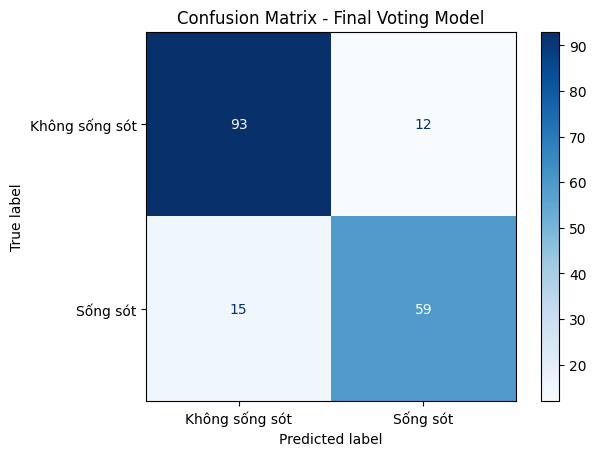

In [15]:
y_pred_val = final_voting_model.predict(X_valid)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_valid, y_pred_val)

# Vẽ confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Không sống sót", "Sống sót"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Final Voting Model")
plt.show()

**Nhận xét**

Mô hình dự đoán khá tốt, khi nhận diện được 93/105 người không sống sót và 59/74 người sống sót. Tuy nhiên vẫn còn:
- 12 người bị dự đoán sai là sống sót (False Positive)
- 15 người bị dự đoán sai là không sống sót (False Negative)

=> Sai lệch này cho thấy mô hình hơi thiên về dự đoán "không sống sót"

In [16]:
import joblib
joblib.dump(final_voting_model, "Voting_Classifier_best_final.pkl")
print("Model saved as Voting_Classifier_best_final.pkl")

Model saved as Voting_Classifier_best_final.pkl


In [17]:
import pandas as pd

test_org = pd.read_csv("../../data/test.csv")

X_test = test.copy()

In [18]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Tạo Voting Classifier với 3 mô hình con và tham số tốt nhất
final_model = VotingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(
            learning_rate=0.05,
            max_depth=3,
            n_estimators=500,
            subsample=0.8,
            min_samples_split=5,
            min_samples_leaf=1,
            random_state=42
        )),
        ('log', LogisticRegression(
            C=0.5,
            max_iter=1000,
            random_state=42
        )),
        ('rf', RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42
        ))
    ],
    voting='soft'
)

final_model.fit(X_train, y_train)

,estimators,"[('gb', ...), ('log', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,loss,'log_loss'
,learning_rate,0.05
,n_estimators,500
,subsample,0.8
,criterion,'friedman_mse'


In [19]:
test_pred = final_model.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test_org["PassengerId"],
    "Survived": test_pred
})

submission.to_csv("submission.csv", index=False)
print("File submission.csv đã được tạo!")

File submission.csv đã được tạo!
